# Project 4: Scraping Sub-Reddits and Using NLP to Compare

# Summary and Introduction

For this project, we were required to scrape two sub-reddits and than use NLP and a Bayes Classifier to try and predict from which sub-reddit the post came. The two sub-reddits that I chose to compare are:

                            -TalesFromYourServer
                            -TalesFromTheCustomer
                      
Mainly all of the posts located in 'TalesFromYourServer' have to do with stories being shared by servers and bartenders about their experiences in the industry. The 'TalesFromTheCustomer' are primarily about customers sharing their experiences in restaurants, but also features stories about other service areas. My objective in this project is to train a model to predict from which sub-reddit each comment, labeled 'selftext', belongs. The scraping of the reddit site has been performed in the first notebook, labeled "Scraping_for_project_4". I successfully scraped 40 pages from each sub-reddit and concatenated the two data frames together. 'TalesFromYourServer' was labeled 0 and 'TalesFromTheCustomer' was labeled 1.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import sklearn.metrics as metrics

from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, make_pipeline


df = pd.read_csv('reddit_scraping.csv')
df = df.drop(columns=['Unnamed: 0'])

In [2]:
df.tail(2)

,author,downs,name,num_comments,permalink,selftext,subreddit,title,ups
1950,aflythatlikespie,0,t3_bksw60,5,/r/TalesFromTheCustomer/comments/bksw60/thanks...,I think this counts because it was in a store....,1,Thanks random guy,47
1951,rooty27k,0,t3_bkv8j0,6,/r/TalesFromTheCustomer/comments/bkv8j0/meat_f...,So my wife (vegetarian) and went out to celebr...,1,Meat filled desserts,12


The dataframe has been seperated into the following columns:


               -Author: The id of the poster
               -Downs: The number of times the post has been down-voted
               -Name: Name of the poster
               -Num_comments: Number of comments that the post recieved
               -Permalink: The address for the post
               -Selftext: The body of the post
               -Title: Title of the post
               -Ups: Numer of times the post has been up-voted

# EDA

In [3]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 9 columns):
author          1952 non-null object
downs           1952 non-null int64
name            1952 non-null object
num_comments    1952 non-null int64
permalink       1952 non-null object
selftext        1911 non-null object
subreddit       1952 non-null int64
title           1951 non-null object
ups             1952 non-null int64
dtypes: int64(4), object(5)
memory usage: 137.3+ KB


In [4]:
df.isna().sum()

author           0
downs            0
name             0
num_comments     0
permalink        0
selftext        41
subreddit        0
title            1
ups              0
dtype: int64

Seeing that there are 41 null items in the 'selftext' category and 1 null item in the title, instead of imputing, since the occurrences are infrequent, I have no problem deleting the rows with these null values. I will still have 1910 rows to work with.

In [5]:
df = df.dropna()
df.isna().sum()

author          0
downs           0
name            0
num_comments    0
permalink       0
selftext        0
subreddit       0
title           0
ups             0
dtype: int64

In [6]:
df.describe()

,downs,num_comments,subreddit,ups
count,1910.0,1910.000000,1910.000000,1910.000000
mean,0.0,29.351309,0.508377,331.490576
std,0.0,57.458725,0.500061,743.086732
min,0.0,0.000000,0.000000,0.000000
25%,0.0,5.000000,0.000000,16.000000
50%,0.0,10.000000,1.000000,39.000000
75%,0.0,25.000000,1.000000,184.000000
max,0.0,701.000000,1.000000,9476.000000


In [7]:
df2 = df.groupby('subreddit')['selftext'].apply(lambda x: np.mean(x.str.len()))
#On average TalesFromTheCustomer posts are longer than those on TalesFromYourServer

In [8]:
df2 = pd.DataFrame(df2)
df2 = df2.reset_index()
df2['subreddit'] = ['Server', 'Customer']

In [9]:
df2['title_length'] = df.groupby('subreddit')['title'].apply(lambda x: np.mean(x.str.len()))

In [10]:
df2['avg_ups'] = df.groupby('subreddit')['ups'].mean()

In [11]:
df2['avg_num_comments'] = df.groupby('subreddit')['num_comments'].mean()

In [12]:
df2

,subreddit,selftext,title_length,avg_ups,avg_num_comments
0,Server,1587.100106,45.275825,272.197018,26.067093
1,Customer,2263.126674,45.283213,388.830072,32.527291


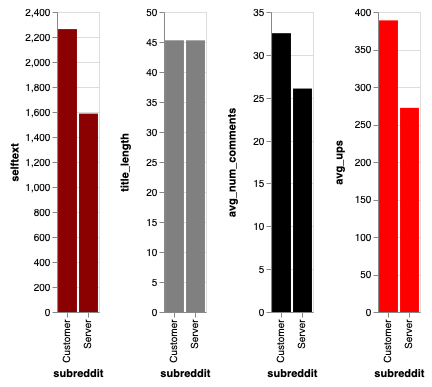

In [13]:
alt.renderers.enable('notebook')

Chart1 = alt.Chart(df2).mark_bar(color='darkred').encode(
    alt.X('subreddit'),
    y='selftext'
)

Chart2 = alt.Chart(df2).mark_bar(color='grey').encode(
    alt.X('subreddit'),
    y='title_length'
)

Chart3 = alt.Chart(df2).mark_bar(color='black').encode(
    alt.X('subreddit'),
    y='avg_num_comments'
)

Chart4 = alt.Chart(df2).mark_bar(color='red').encode(
    alt.X('subreddit'),
    y='avg_ups'
)

Chart1 | Chart2 | Chart3 | Chart4

As the bargraphs show, there are some noticeable differences between the two sub-reddits. 'TalesFromTheCustomer' has, on average, longer posts, more comments, and more ups.


Considering I did the scraping myself, I am fairly confident that there will not be an imbalance in the target value. But I will double check!

In [14]:
df['subreddit'].value_counts() 

1    971
0    939
Name: subreddit, dtype: int64

In [15]:
df.dtypes

author          object
downs            int64
name            object
num_comments     int64
permalink       object
selftext        object
subreddit        int64
title           object
ups              int64
dtype: object

# Cleaning: Tokenizing and Lemmatizing

In [16]:
lemmatizer = WordNetLemmatizer()
st = df['selftext'].tolist()

In [17]:
def clean_reddit(raw_review):
    lower_case = raw_review.lower()
    retokenizer = RegexpTokenizer(r'[a-z]+')
    words = retokenizer.tokenize(lower_case)
    return(lemmatizer.lemmatize(" ".join(words)))

In [18]:
num_posts = df['selftext'].size
clean_posts = []

for i in range(0, num_posts):
        clean_posts.append( clean_reddit( st[i] ))

In [19]:
df['selftext'] = clean_posts

In [20]:
df.head(2)

,author,downs,name,num_comments,permalink,selftext,subreddit,title,ups
0,WalkinSteveHawkin,0,t3_at8kic,250,/r/TalesFromYourServer/comments/at8kic/dedicat...,hi all amp x b i realized our new server advic...,0,Dedicated thread for new server advice,113
1,BraskytheSOB,0,t3_bmkpp8,10,/r/TalesFromYourServer/comments/bmkpp8/im_a_so...,short and sweet one today prime steak house wo...,0,"""I'm a sommmelier"" woman orders house malbec. ...",110


# Labeling x and y and Train Test Split

In [21]:
x = df['selftext']
y = df['subreddit']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42, shuffle=True, stratify=y)
#Making sure that we are shuffling the data as it is in order and stratifying y.

In [23]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1528,)
(1528,)
(382,)
(382,)


# MODEL 1: COUNT VECTORIZER

In [24]:
cvec = CountVectorizer(stop_words='english', 
                       lowercase=True, 
                       ngram_range=(1,2),
                       strip_accents='unicode',
                      )

In [25]:
train_data_features2 = cvec.fit_transform(x_train.apply(lambda x: np.str_(x)))

train_data_features2

<1528x186967 sparse matrix of type '<class 'numpy.int64'>'
	with 381123 stored elements in Compressed Sparse Row format>

In [26]:
train_data_features2.todense()

df_cv = pd.DataFrame(train_data_features2.todense(), columns=cvec.get_feature_names())

df_cv.head(2)

,aaaaall,aaaaall chose,aaaasndnsncjfmdks,aaaasndnsncjfmdks hate,aaand,aaand ask,aaeq,aaeq fun,aand,aand cutting,...,zoom thing,zoos,zoos decided,zu,zu schnauzer,zurich,zurich drinks,zuynht,zz,zz xxxxx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
Z_train = df_cv.copy()
#Making a copy for the Bayes Classifier later.

In [28]:
test_data_features2 = cvec.transform(x_test.apply(lambda x: np.str_(x)))

In [29]:
test_data_features2.todense()

Z_test = pd.DataFrame(test_data_features2.todense(), columns=cvec.get_feature_names())

Z_test.head()

,aaaaall,aaaaall chose,aaaasndnsncjfmdks,aaaasndnsncjfmdks hate,aaand,aaand ask,aaeq,aaeq fun,aand,aand cutting,...,zoom thing,zoos,zoos decided,zu,zu schnauzer,zurich,zurich drinks,zuynht,zz,zz xxxxx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
log_reg = LogisticRegression()
log_reg.fit(train_data_features2, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
print(log_reg.score(train_data_features2, y_train))
print(log_reg.score(test_data_features2, y_test))

1.0
0.887434554973822


In [32]:
word_count = df_cv.sum(axis=0)
word_count.sort_values(ascending=False).head(20)

just       2959
like       1858
time       1504
know       1288
don        1279
didn       1264
said       1252
food       1216
order      1181
got        1104
manager    1084
people     1030
told        999
table       936
ve          904
really      852
want        848
went        842
did         830
work        825
dtype: int64

In [33]:
df_cv['target'] = y_train

In [52]:
wc = df_cv.groupby(['target']).sum(axis=0)
#Counting word frequency between the two different subreddits

In [53]:
df_server_freq = wc.iloc[:1, :]
df_customer_freq = wc.iloc[1:, :]

df_server_words = df_server_freq.sum(axis=0)
s_sort = df_server_words.sort_values(ascending=False).head(20)

df_customer_words = df_customer_freq.sum(axis=0)
c_sort = df_customer_words.sort_values(ascending=False).head(20)

most_common_words1 = pd.DataFrame(s_sort).reset_index()
most_common_words2 = pd.DataFrame(c_sort).reset_index()

In [54]:
most_common_words = pd.merge(most_common_words1, most_common_words2, on='index')

In [55]:
most_common_words = most_common_words.rename(columns={'index': 'words', '0_x': 'server', '0_y': 'customer'})

In [56]:
most_common_words

,words,server,customer
0,just,1489,833
1,like,908,555
2,time,741,450
3,said,635,345
4,didn,630,371
5,don,630,377
6,know,622,372
7,food,619,345
8,order,597,334
9,got,552,325


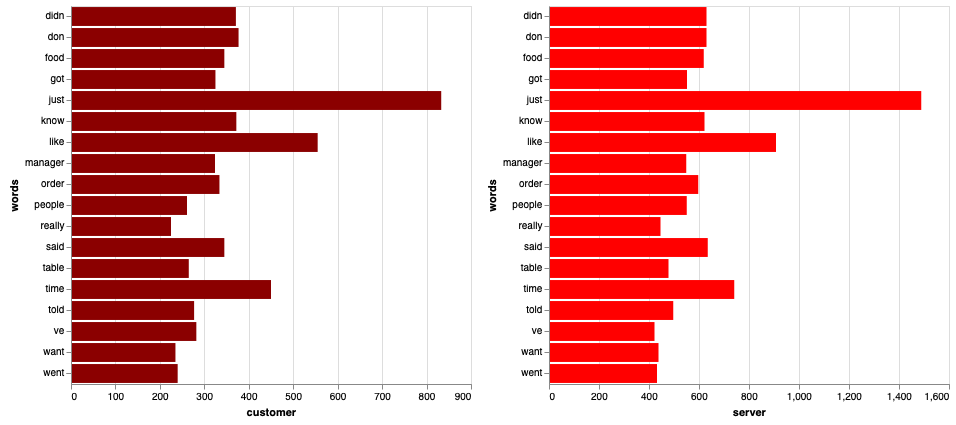

In [57]:

Chart_A = alt.Chart(most_common_words).mark_bar(color='darkred').encode(
    x='customer',
    y='words'
)

Chart_B = alt.Chart(most_common_words).mark_bar(color='red').encode(
    x='server',
    y='words'
)

alt.hconcat(Chart_A, Chart_B)

These visualizations are very telling. It is interesting that they have the same shape, but the scale on the server chart (on the right) is much higher. Of the 20 most frequently used words, 18 were present in both target sets. "Work" is one of the words that is in the top 20 most common for 'TalesFromYourServer' and not in 'TalesFromTheCustomer'. I would assume that the reason for these similar shapes, but larger scale on the 'TalesFromYourServer', is probably due to the fact that that sub-reddit is dedicated solely to the restaurant service industry and those who work in it. While 'TalesFromTheCustomer' is a majority customers at restaurants, there do exist a fair number of other various service industries that these posters are writing about. I would assume that if this sub-reddit was dedicated solely to customers at restaurants and bars, the scales would be much more similar. 

If I were to re-do this section, I would add stopwords, in addition to the ones already in the Count Vectorizer. Words, such as "want", "went" and "did" should be filtered out.

# MODEL 2: TF-IDF

In [ ]:
# tvec = TfidfVectorizer(stop_words='english')
# train_data_tfid = tvec.fit_transform(x_train.apply(lambda x: np.str_(x)))

# test_data_tfid = tvec.transform(x_test.apply(lambda x: np.str_(x)))

# model = LogisticRegression()
# model.fit(train_data_tfid, y_train)

# print(model.score(train_data_tfid, y_train))
# print(model.score(test_data_tfid, y_test))

After doing different models, the TF-IDF had the best score. Thus, I am placing the TF-IDF model in a pipeline for future use.

In [36]:
pipe = make_pipeline(TfidfVectorizer(stop_words="english",
                                     max_features=1000,
                                    ngram_range=(1,5)),
                      LogisticRegression(),
                     ) #If the cleaning/tokenizing occurred after the train test split, I would include this step in the pipeline.

pipe.fit(x_train, y_train)
predictions = pipe.predict(x_test)
print(accuracy_score(y_test, predictions))

0.8979057591623036


# MODEL 3: NAIVE BAYES

In [37]:
Z_train.head()

,aaaaall,aaaaall chose,aaaasndnsncjfmdks,aaaasndnsncjfmdks hate,aaand,aaand ask,aaeq,aaeq fun,aand,aand cutting,...,zoom thing,zoos,zoos decided,zu,zu schnauzer,zurich,zurich drinks,zuynht,zz,zz xxxxx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
model3 = MultinomialNB()

In [39]:
model3.fit(Z_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
predictions = model3.predict(Z_test)

In [41]:
model3.score(Z_test, y_test)

0.8534031413612565

In [42]:
confusion_matrix(y_test, predictions)

array([[143,  45],
       [ 11, 183]])

In [43]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [44]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 143
False Positives: 45
False Negatives: 11
True Positives: 183


0.8519686334722526


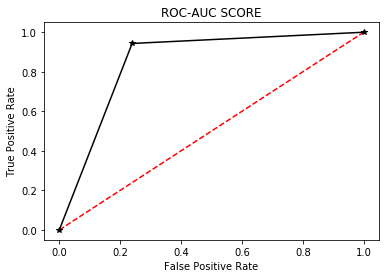

In [45]:
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot

auc = roc_auc_score(y_test, predictions)
print(auc)

fp, tp, thresholds = roc_curve(y_test, predictions)

pyplot.plot([0, 1], [0, 1], linestyle='--', c='r')

pyplot.plot(fp, tp, marker='*', c='k')
pyplot.ylabel('True Positive Rate')
pyplot.xlabel('False Positive Rate')
pyplot.title('ROC-AUC SCORE')
pyplot.show()

# Future Predictions

Now I will test my best model, the TF-IDF on a simulated new piece of data, randomly chosen from the test set.

In [49]:
i = 2
x_test.iloc[i : i + 1].to_dict()

{1491: 'there are many stories i could tell which fit in this sub but this one is by far the most interesting one tldr at the bottom my mother owns a little shop which sells cute stuff and presents i also work there sometimes to help her and because we are living in a very small town in germany she knows many people there she made a friend let s call her sheila who always came to our shop sometimes just to chat so when sheila told us she owned a restaurant my mother wanted to surprise her by going there next week so my mom and me were both working in her shop then in our break at work from pm to pm lunch break she wanted to go to sheila s restaurant we both sat at the table as the waiter did not came at first he was standing behind the corner and played something on his mobile phone then as my mother had waited a few minutes and nobody but us was there she waved him over we both ordered noodles and waited so long for them that i had to go back to our store and had to put a sign on the 

In [50]:
new_data = pd.DataFrame(
    [x_test.iloc[i : i + 1]])

new_data = new_data.T

new_data['selftext']

1491    there are many stories i could tell which fit ...
Name: selftext, dtype: object

In [51]:
pipe.predict(new_data['selftext'])

array([1])

The TF-IDF model accurately predicted that "new data" was classified as 1 (TalesFromTheCustomer)

# Summary and Conclusion

The best model was the TF-IDF with the Logistic Regression. While it did not score as high as the Count Vectorizer in the training data, it scored slightly better in the testing data, with .898. The accuracy of all three models is surprising, in that, the most frequently used word count for both subreddits included many similar words, and the topics, in and of themselves, are quite similar in objective. If I could re-do the project, I would spend more time on filtering out stop words. I assume that this could raise the score into the .90s. However, all models performed very well scoring between 84-90% margin on the test sets. 